# Improving predictions from multi-modal models

## Quantum Solution
Implementation of a variational quantum circuit that replaces last layer of a traditional neural network, as proposed in [this paper](https://www.sciencedirect.com/science/article/pii/S1566253523002294?ref=pdf_download&fr=RR-2&rr=87b0521c7a8d0377). A similar approach has been chosen in [this paper](https://www.sciencedirect.com/science/article/pii/S1566253523004888). The code is influenced by Pennylane [blogpost](https://pennylane.ai/qml/demos/tutorial_variational_classifier/).

In [167]:
# Imports
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

In [168]:
dev = qml.device("default.qubit")
n_qubits = 4 # number of qubits, max supported input features: 2 ** n_qubits
n_layers = 2 # layers of variational circuit: more layers -> more expressive circuit but more weigths to optimize, more succeptible to noise

In [169]:
# Functions to create circuit
bonds = []
for i in range(n_qubits):
    if i > 0:
        bonds.append([i-1, i])
bonds.append([n_qubits-1, 0])

def layer(layer_weights):
    for wire in range(n_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)
    for wires in bonds:
        qml.CNOT(wires)


@qml.qnode(dev)
def circuit(weights, x):
    qml.AmplitudeEmbedding(x, wires=range(n_qubits), pad_with=True, normalize=True)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, x):
    return (circuit(weights, x) + 1)

0: ─╭|Ψ⟩──Rot(1.76,0.40,0.98)───╭●───────╭X──Rot(0.76,0.12,0.44)───╭●───────╭X─┤  <Z>
1: ─├|Ψ⟩──Rot(2.24,1.87,-0.98)──╰X─╭●────│───Rot(0.33,1.49,-0.21)──╰X─╭●────│──┤     
2: ─├|Ψ⟩──Rot(0.95,-0.15,-0.10)────╰X─╭●─│───Rot(0.31,-0.85,-2.55)────╰X─╭●─│──┤     
3: ─╰|Ψ⟩──Rot(0.41,0.14,1.45)─────────╰X─╰●──Rot(0.65,0.86,-0.74)────────╰X─╰●─┤     


(<Figure size 1400x500 with 1 Axes>, <Axes: >)

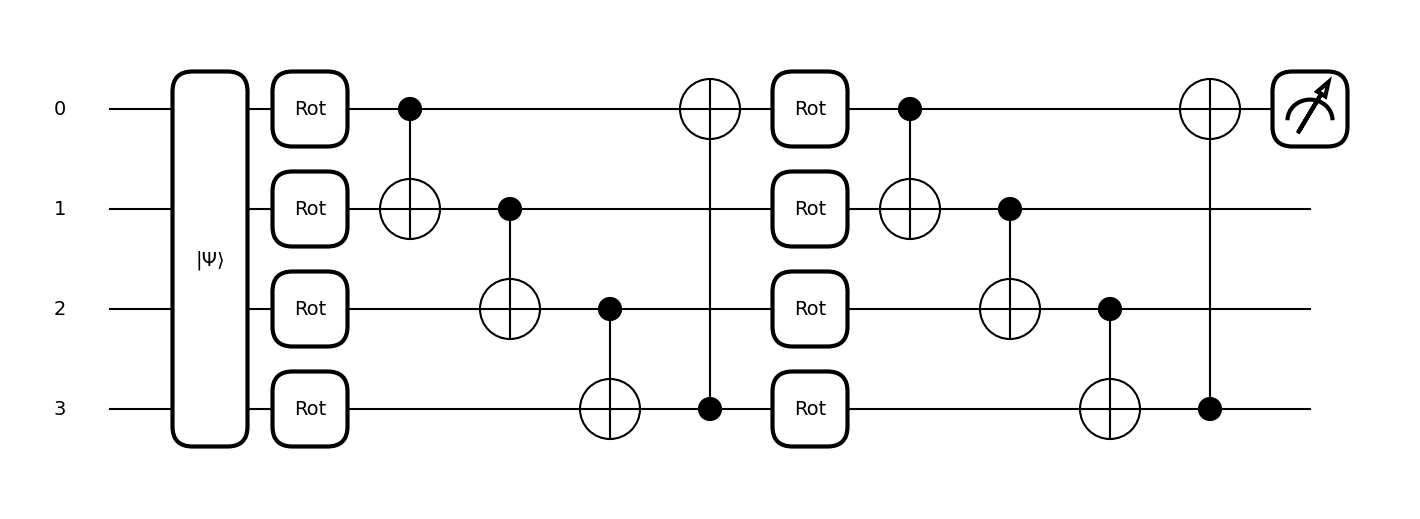

In [203]:
# draw circuit
np.random.seed(0)
test_weights = np.random.randn(n_layers, n_qubits, 3, requires_grad=True)
test_ampl = np.random.randn(n_qubits**2)

print(qml.draw(circuit)(test_weights, test_ampl))
qml.draw_mpl(circuit, dpi="300")(test_weights, test_ampl)

In [171]:
# define cost function
def cost(weights, X, Y):
    predictions = [variational_classifier(weights, x) for x in X]

    # we use squared loss
        # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((Y - qml.math.stack(predictions)) ** 2)

In [179]:
# load data
data = np.loadtxt("output.txt")
X = data[:, :-1]
print(f"First X feature vector: {X[0]}")
print(f"number of features: {len(X[0])}")

Y = data[:, -1] / 10 # normalize to go from 0 to 1
print(f"\nFirst Y label: {Y[0]}")

First X feature vector: [-0.53119081  0.44133833 -0.73029804 -1.24838483 -0.89459074  0.01993603
 -0.02669168 -0.06708672 -0.00409688  0.00714142]
number of features: 10

First Y label: 0.1


### Training of QML network

In [180]:
# split training and validation set
#np.random.seed(0)
train_ratio = 0.6
num_data = len(Y)
num_train = int(train_ratio * num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[:num_train]]
Y_train = Y[index[:num_train]]
X_val = X[index[num_train:]]
Y_val = Y[index[num_train:]]

print(f"Size of training dataset: {len(Y_train)}")
print(f"Size of validation dataset: {len(Y_val)}")

Size of training dataset: 12
Size of validation dataset: 8


In [181]:
# initiate optimizer
opt = NesterovMomentumOptimizer(0.01)

In [182]:
# initiate weights
weights_init = 0.01 * np.random.randn(n_layers, n_qubits, 3, requires_grad=True)

In [186]:
# training in batches

batch_size = 5

weights = weights_init
train_loss = []
val_loss = []

for i in range(100):

    batch_index = np.random.randint(0, num_train, batch_size)
    #print(batch_index)
    X_temp = X_train[batch_index]
    Y_temp = Y_train[batch_index]
    #print(Y_temp)
    #weights, _, _ = opt.step(cost, weights, X_temp, Y_temp)
    weights = opt.step(lambda v: cost(v, X_temp, Y_temp), weights)
    # print(weights)
    # print(weights.shape)
    # print(temp)
    # print(temp.shape)

    train_loss_temp = cost(weights, X_train, Y_train)
    print(f"Training loss after iteration {i}: {np.round(train_loss_temp, 2)}")
    train_loss.append(train_loss_temp)

    val_loss_temp = cost(weights, X_val, Y_val)
    print(f"Validation loss after iteration {i}: {np.round(val_loss_temp, 2)}")
    val_loss.append(val_loss_temp)

Training loss after iteration 0: 0.33
Validation loss after iteration 0: 0.31
Training loss after iteration 1: 0.33
Validation loss after iteration 1: 0.31
Training loss after iteration 2: 0.33
Validation loss after iteration 2: 0.31
Training loss after iteration 3: 0.32
Validation loss after iteration 3: 0.31
Training loss after iteration 4: 0.31
Validation loss after iteration 4: 0.3
Training loss after iteration 5: 0.31
Validation loss after iteration 5: 0.3
Training loss after iteration 6: 0.3
Validation loss after iteration 6: 0.3
Training loss after iteration 7: 0.29
Validation loss after iteration 7: 0.29
Training loss after iteration 8: 0.28
Validation loss after iteration 8: 0.29
Training loss after iteration 9: 0.28
Validation loss after iteration 9: 0.28
Training loss after iteration 10: 0.27
Validation loss after iteration 10: 0.28
Training loss after iteration 11: 0.26
Validation loss after iteration 11: 0.27
Training loss after iteration 12: 0.26
Validation loss after ite

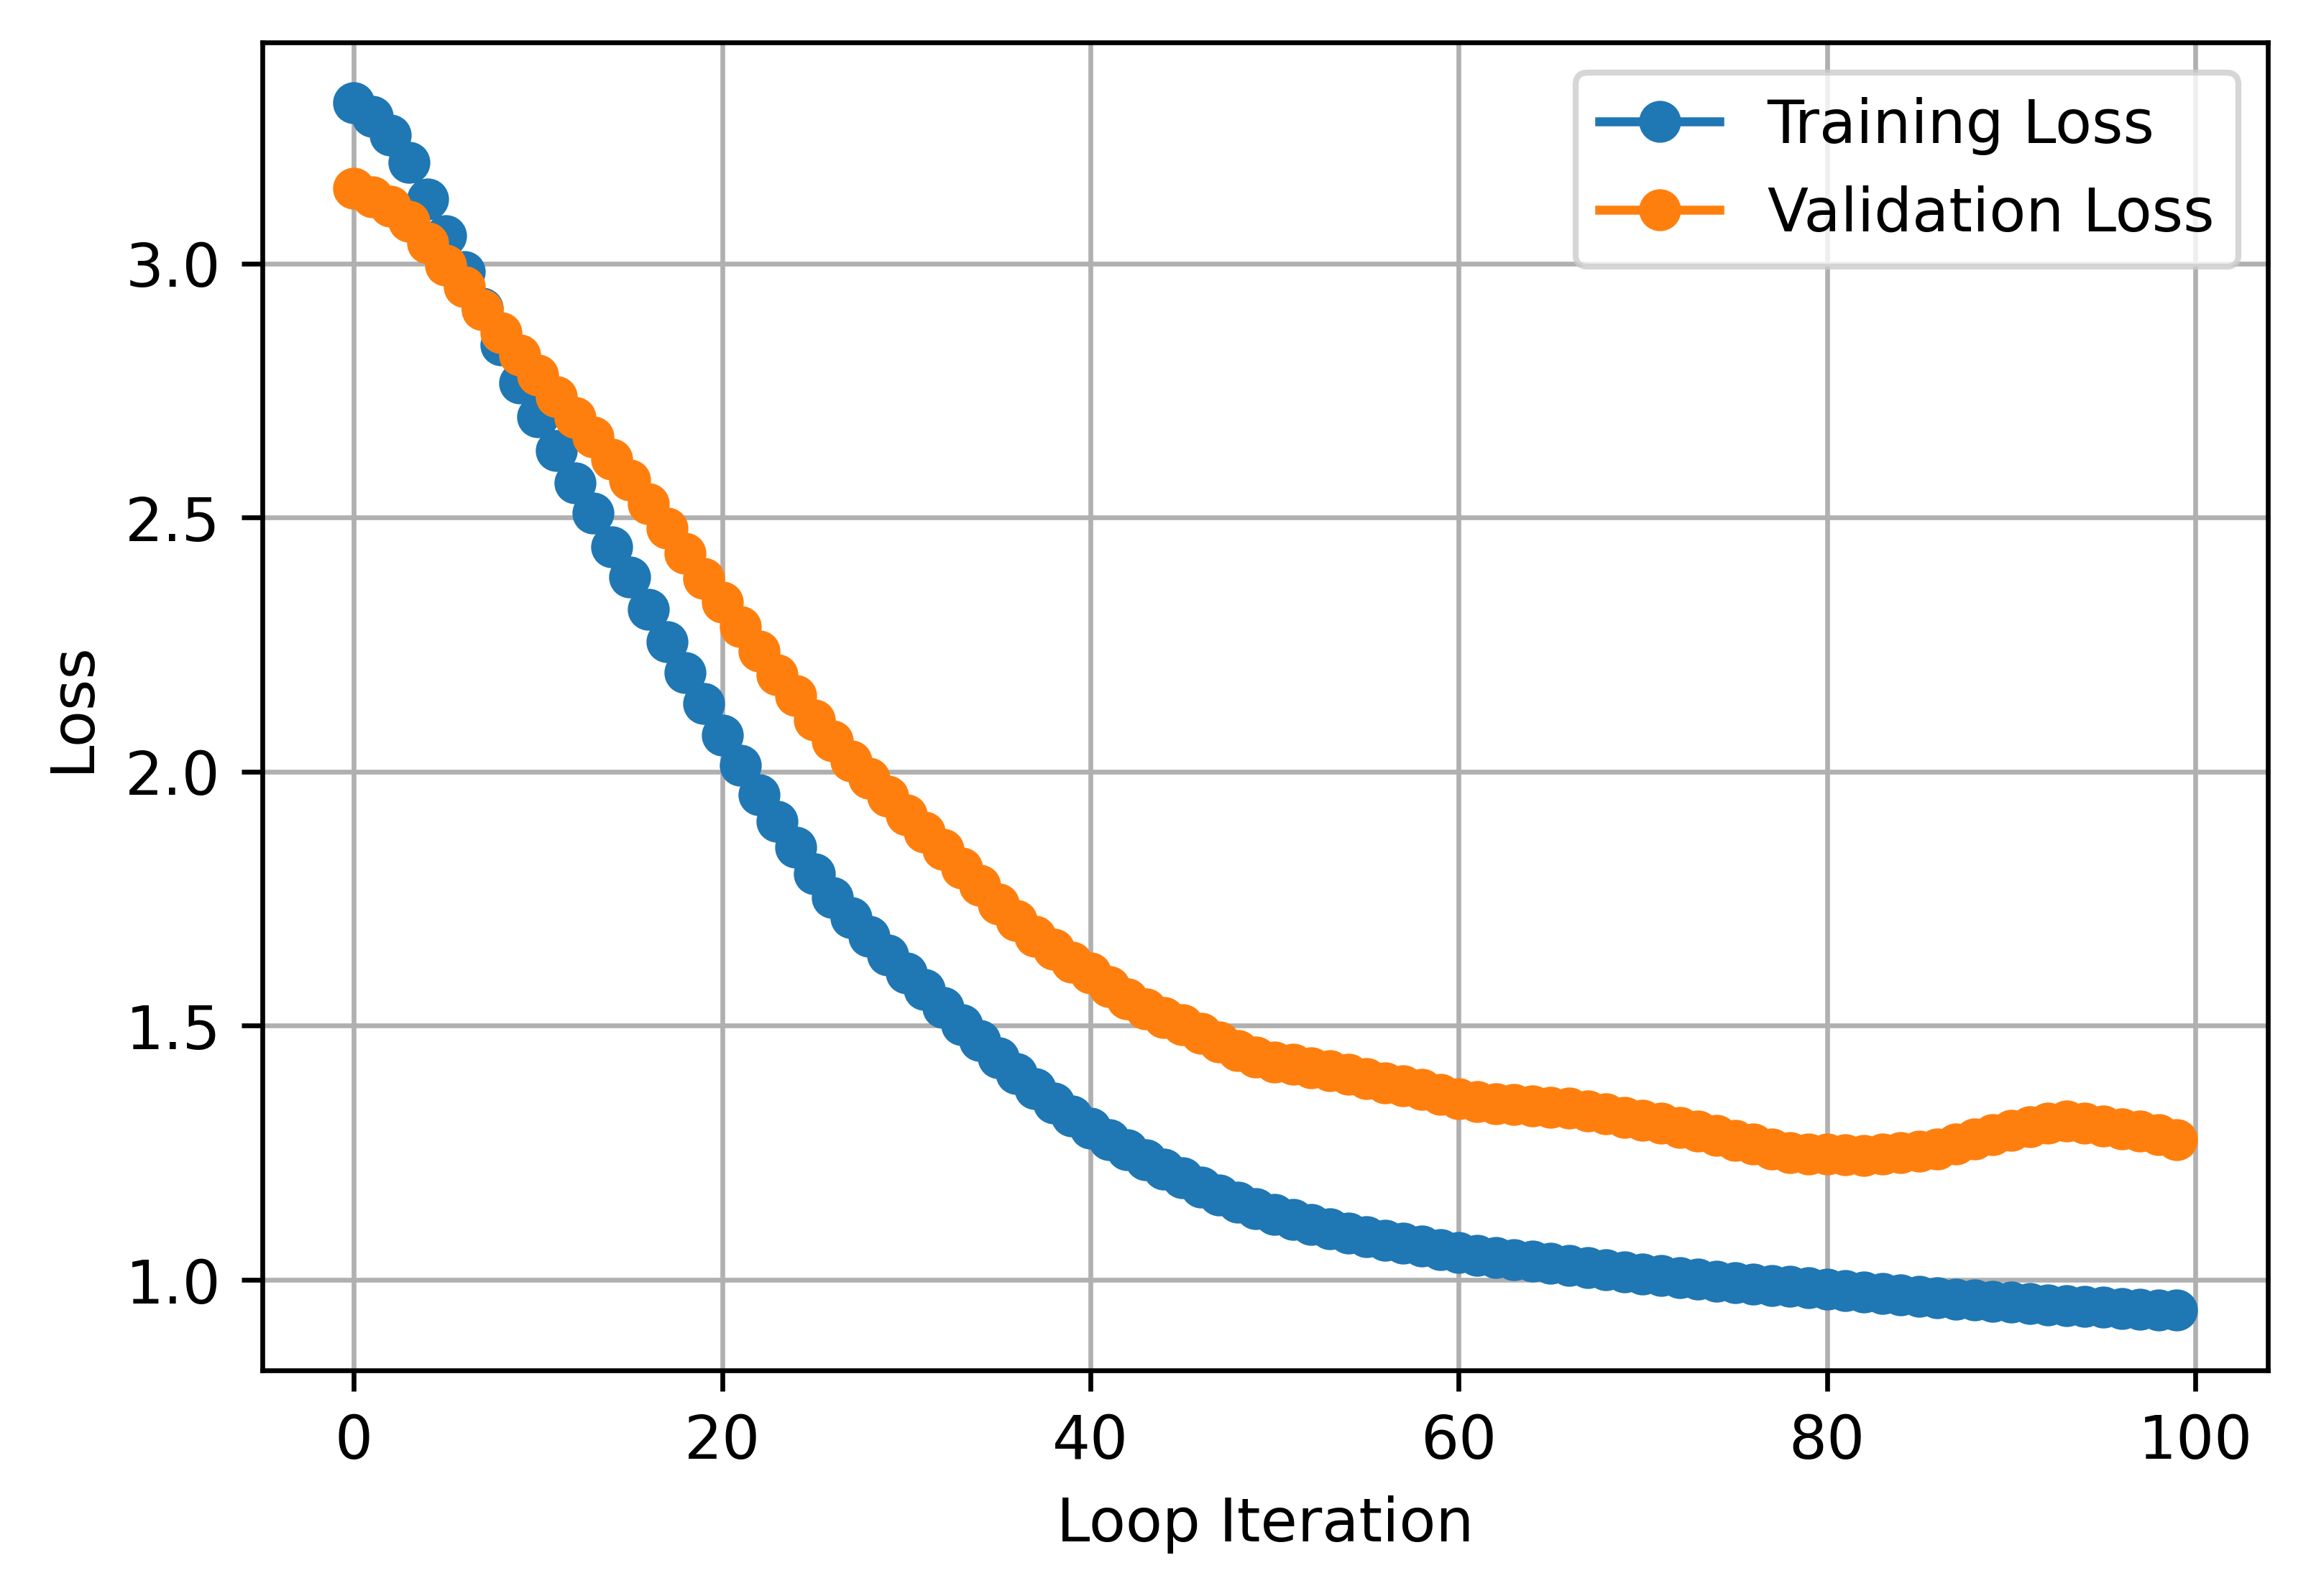

In [212]:
# NOTE to judges potentially executing this code: bare in mind that we did not fix the seed for
# randomness, so every execution will lead to slightly different results

plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = [6, 4]
# *10 because we had divided the value by 10 before (to make the value [0,1])
train_loss_mult = [10*x for x in train_loss]
val_loss_mult = [10*x for x in val_loss]

plt.plot(train_loss_mult, '-o', label="Training Loss") 
plt.plot(val_loss_mult, '-o',label="Validation Loss")
plt.grid()
plt.legend()
plt.xlabel("Loop Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
print(f"Standard deviation for the predition of the safety value on a scale from 0-10:\n{round(val_loss_mult[-1], 2)}")

## Classical prediction
Using fully connected layer instead of VQC, in order to compare performance

In [214]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

In [215]:
# (re)load data
data = np.loadtxt("output.txt")
X = data[:, :-1]
print(f"First X feature vector: {X[0]}")
print(f"number of features: {len(X[0])}")

Y = data[:, -1] / 10 # normalize to go from 0 to 1
print(f"\nFirst Y label: {Y[0]}")

First X feature vector: [-0.53119081  0.44133833 -0.73029804 -1.24838483 -0.89459074  0.01993603
 -0.02669168 -0.06708672 -0.00409688  0.00714142]
number of features: 10

First Y label: 0.1


In [216]:
# Define input and output size
input_size = len(X[0])
output_size = 1
batch_size = 5
num_epochs = 300
train_ratio = 0.6


# Define a simple neural network with one fully connected layer
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

dataset_size = Y.shape[0]
x_data = torch.from_numpy(X).to(dtype=torch.float32)
Y_dims = np.array([[y] for y in Y])
y_data = torch.from_numpy(Y_dims).to(dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(x_data, y_data)

# Split into training and validation sets
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = Net(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_loss_track = []
val_loss_track = []
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    train_total_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        train_total_loss += loss.item()  # Accumulate the loss

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_total_loss = 0.0
    with torch.no_grad():  # No gradient computation during evaluation
        for inputs, targets in val_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_total_loss += loss.item()  # Accumulate the loss

    # Calculate average loss for training and validation
    avg_train_loss = train_total_loss / len(train_loader)
    avg_val_loss = val_total_loss / len(val_loader)

    train_loss_track.append(avg_train_loss)
    val_loss_track.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}")

Epoch [1/100], Training Loss: 0.3424, Validation Loss: 0.2550
Epoch [2/100], Training Loss: 0.3249, Validation Loss: 0.2521
Epoch [3/100], Training Loss: 0.3119, Validation Loss: 0.2493
Epoch [4/100], Training Loss: 0.2984, Validation Loss: 0.2466
Epoch [5/100], Training Loss: 0.2875, Validation Loss: 0.2440
Epoch [6/100], Training Loss: 0.2786, Validation Loss: 0.2415
Epoch [7/100], Training Loss: 0.2646, Validation Loss: 0.2391
Epoch [8/100], Training Loss: 0.2566, Validation Loss: 0.2367
Epoch [9/100], Training Loss: 0.2478, Validation Loss: 0.2344
Epoch [10/100], Training Loss: 0.2379, Validation Loss: 0.2322
Epoch [11/100], Training Loss: 0.2276, Validation Loss: 0.2301
Epoch [12/100], Training Loss: 0.2209, Validation Loss: 0.2281
Epoch [13/100], Training Loss: 0.2120, Validation Loss: 0.2262
Epoch [14/100], Training Loss: 0.2051, Validation Loss: 0.2243
Epoch [15/100], Training Loss: 0.1992, Validation Loss: 0.2224
Epoch [16/100], Training Loss: 0.1922, Validation Loss: 0.2206
E

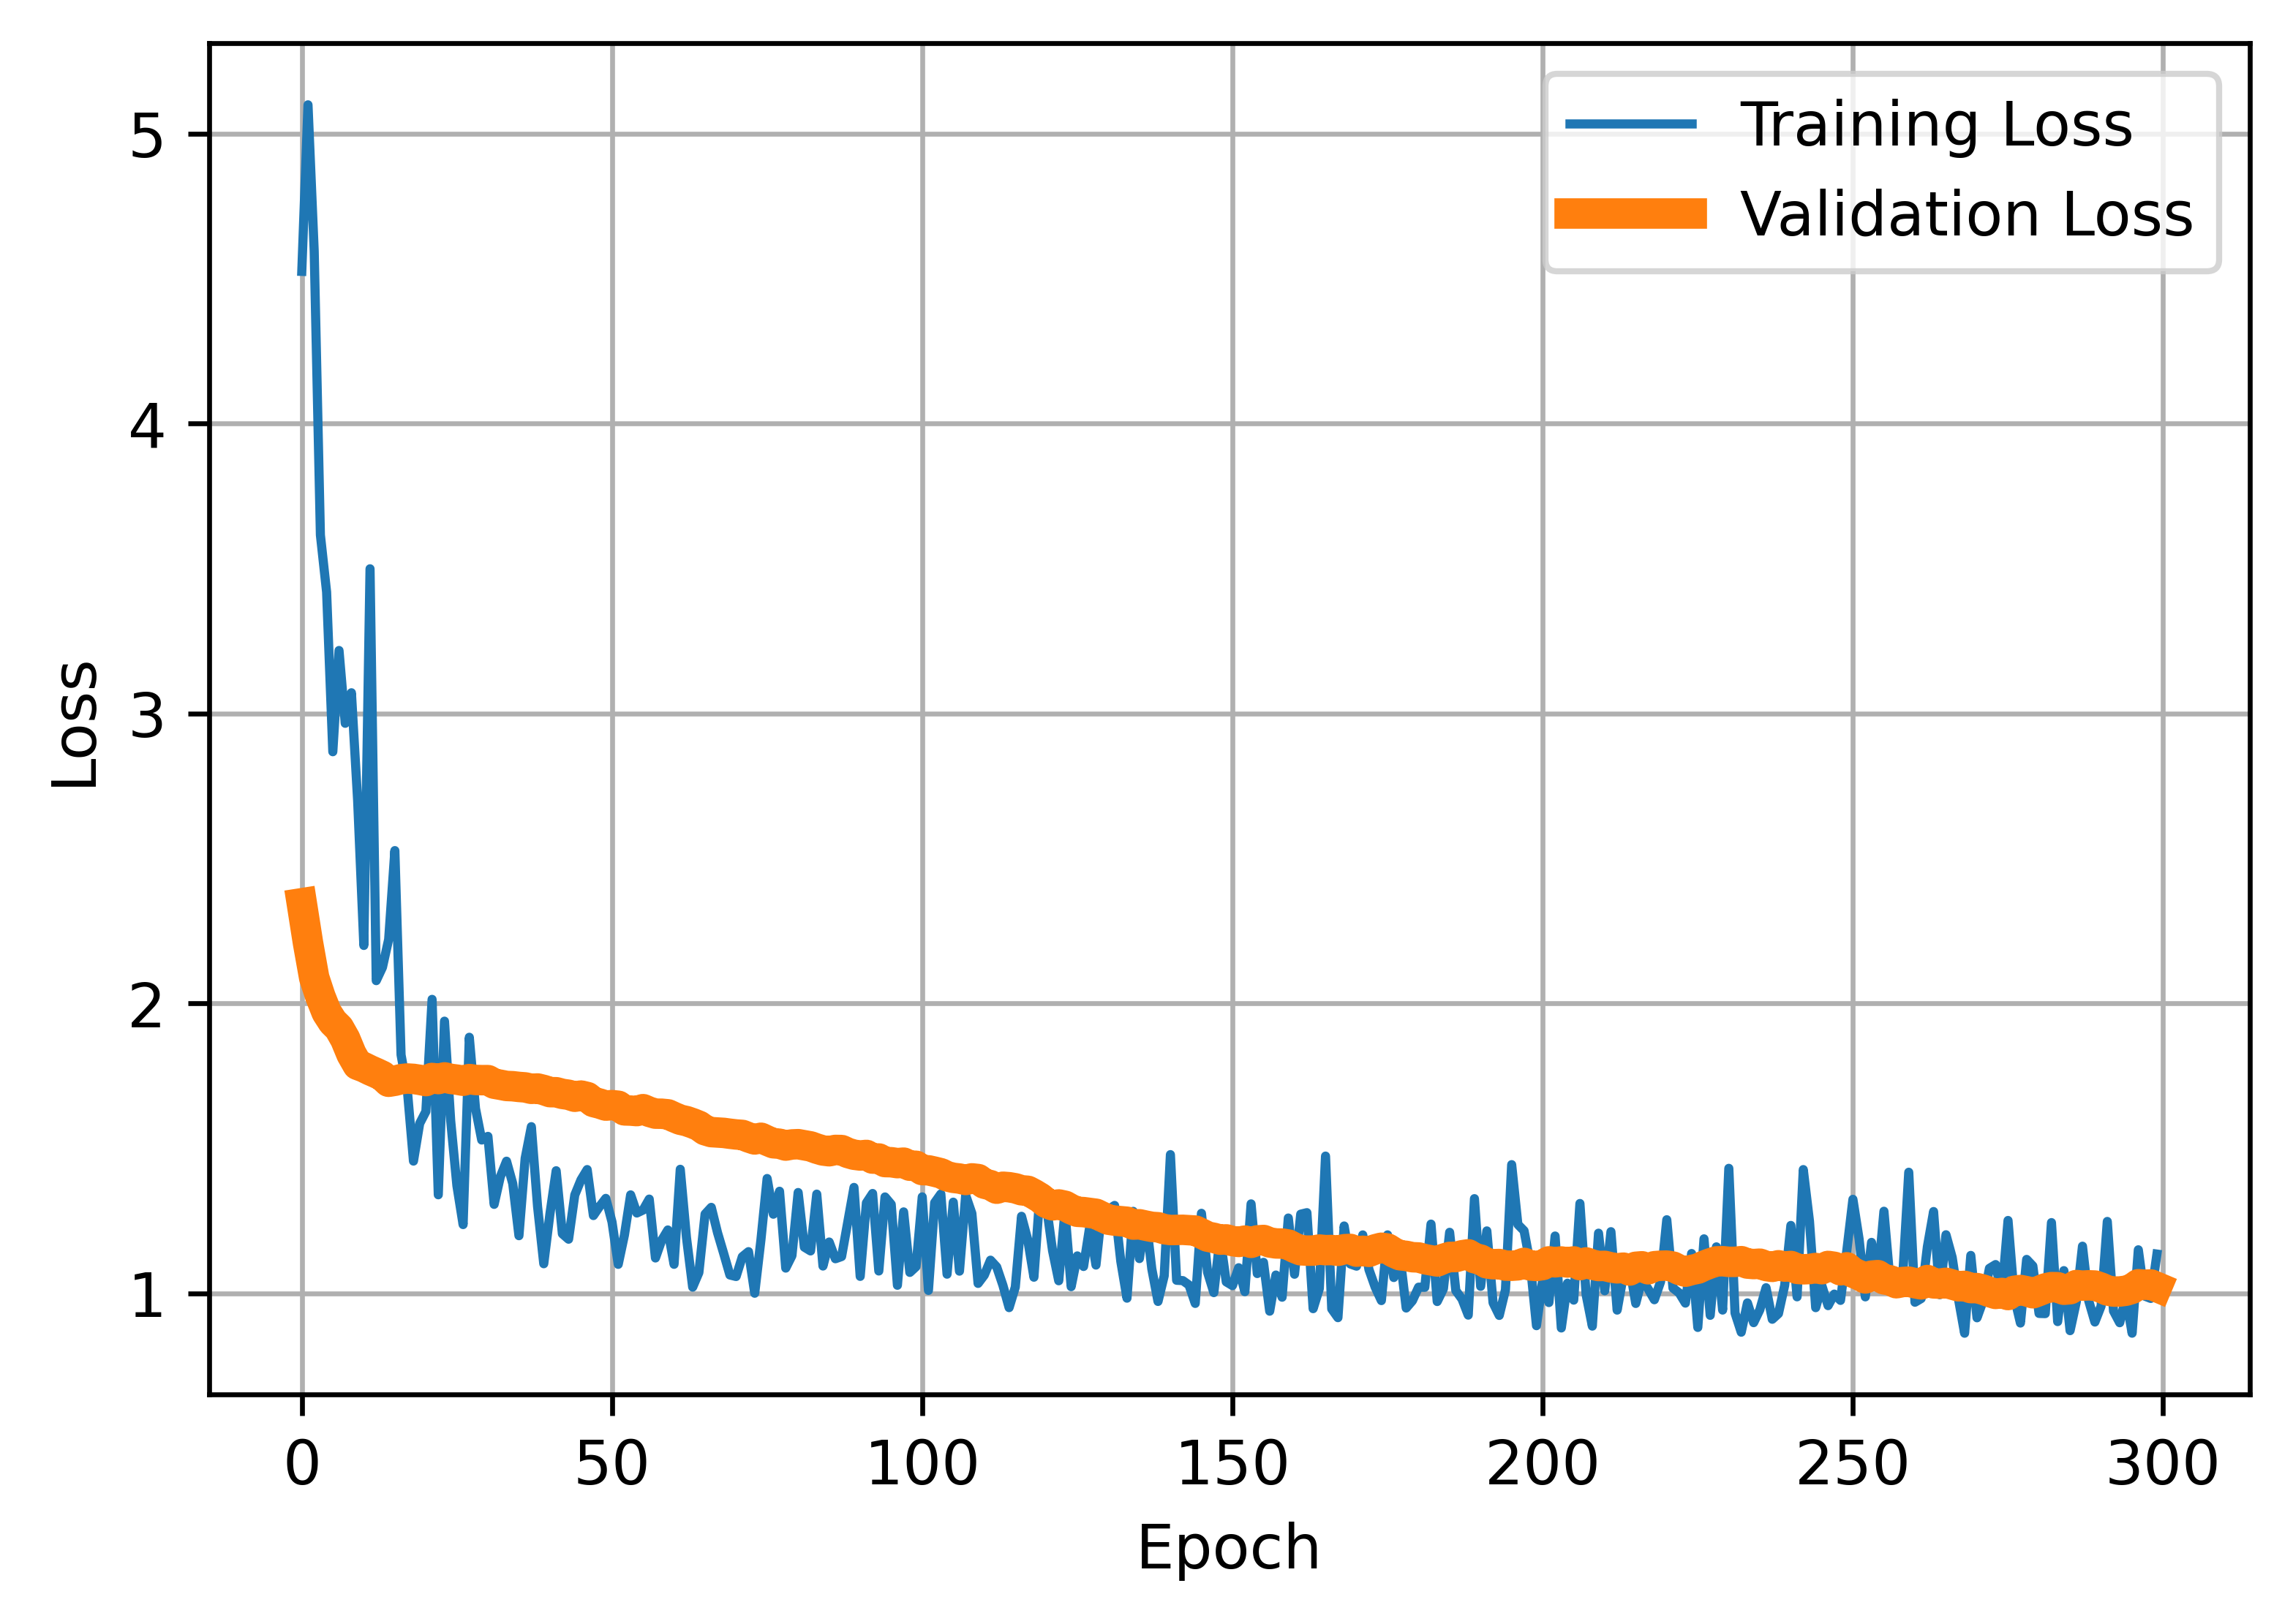

In [213]:
# *10 because we had divided the value by 10 before (to make the value [0,1])
train_loss_track_mult = [10*x for x in train_loss_track]
val_loss_track_mult = [10*x for x in val_loss_track]

plt.plot(train_loss_track_mult, '-', label="Training Loss")
plt.plot(val_loss_track_mult, '-', label="Validation Loss", linewidth=5)
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
print(f"Standard deviation for the predition of the safety value on a scale from 0-10:\n{round(val_loss_track_mult[-1], 2)}")